In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dirname = "book"
img1 = cv.imread(f'./data/{dirname}/left_0.jpg', cv.IMREAD_GRAYSCALE)
img2 = cv.imread(f'./data/{dirname}/right_0.jpg', cv.IMREAD_GRAYSCALE)

In [3]:
# Detect SIFT features
sift = cv.SIFT_create()

# Find keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [4]:
# Do FLANN matching
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

pts1 = []
pts2 = []

# Filter
for i, (m,n) in enumerate(matches):
    if m.distance < 0.8 * n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [5]:
# Determine the Fundamental matrix
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(
    points1=pts1,
    points2=pts2,
    method=cv.FM_LMEDS
)

# Select only the inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [6]:
# Draw epilines on second image
def drawlines(img1, img2, lines, pts1, pts2):
    """
    img1 - image on which we draw epilines from points in img2
    """
    r, c = img1.shape
    
    # Back to color
    img1 = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])

        img1 = cv.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

In [7]:
# Find epilines corresponding to points in second image,
# and draw the lines on the first image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img7, img8 = drawlines(img2, img1, lines2, pts2, pts1)

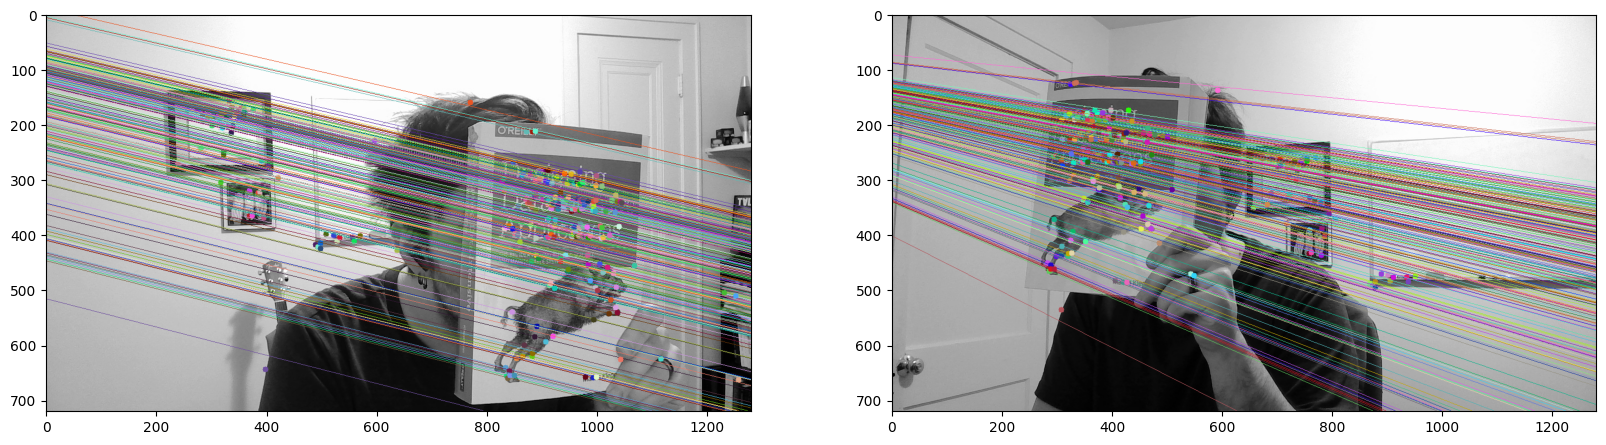

In [8]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(121)
plt.imshow(img5)
fig.add_subplot(122)
plt.imshow(img7)